# Кластеризация

## 0 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import v_measure_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram

## 1 Подготовка данных

In [2]:
url = 'https://raw.githubusercontent.com/otverskoj/First-steps-in-Data-Analysis/main/datasets/classification/occupancy_detection_preprocessed.csv'
names = ['date', 'temperature', 'humidity', 'light', 'co2', 'humidity_ratio', 'occupancy']
df = pd.read_csv(url, names=names, skiprows=1).reset_index(drop=True).drop(['date'], axis=1)

In [3]:
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaled_X = scaler.transform(X)

## 2 Метод k-means (k-средних)

Это итеративный алгоритм кластеризации, основанный на минимизации суммарных квадратичных отклонений точек кластеров от центроидов (средних координат) этих кластеров.

Первоначально выбирается желаемое количество кластеров n_clusters. 

Теперь случайным образом из входных данных выбираются n_clusters элементов выборки, в соответствие которым ставятся n_clusters кластеров, в каждый из которых теперь включено по одной точке, каждая при этом является центроидом этого кластера.

Далее ищем ближайшего соседа текущего центроида. Добавляем точку к соответствующему кластеру и пересчитываем положение центроида с учетом координат новых точек. Алгоритм заканчивает работу, когда координаты каждого центроида перестают меняться. Центроид каждого кластера в результате представляет собой набор значений признаков, описывающих усредненные параметры выделенных классов.

In [4]:
n_clusters = np.unique(y).shape[0]
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_train)
predicted_labels = kmeans.predict(X_test)
print(f"Качество работы k-means на итерации: {v_measure_score(y_test, predicted_labels)}")

Качество работы k-means на итерации: 0.4677724734777283


## 3 Иерархическая кластеризация

Иерархическая кластеризация представляет собой алгоритм, который строит иерархию кластеров. Этот алгоритм начинает работу с того, что каждому экземпляру данных сопоставляется свой собственный кластер. Затем два ближайших кластера объединяются в один и так далее, пока не будет образован один общий кластер.

Результат иерархической кластеризации может быть представлен с помощью дендрограммы.

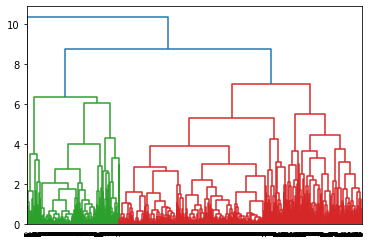

In [5]:
# Исключаем информацию об образцах зерна, сохраняем для дальнейшего использования
samples, varieties = scaled_X, y

# Реализация иерархической кластеризации при помощи функции linkage
mergings = linkage(samples, method='complete')

# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

## 4 Понижение размерности с методом t-SNE

Метод t-SNE (t-distributed stochastic neighbor embedding) представляет собой один из методов обучения без учителя, используемых для визуализации, например, отображения пространства высокой размерности в двух- или трехмерное пространство. t-SNE расшифровывается как распределенное стохастическое соседнее вложение.

Метод моделирует каждый объект пространства высокой размерности в двух- или трехкоординатную точку таким образом, что близкие по характеристикам элементы данных в многомерном пространстве (например, датасете с большим числом столбцов) проецируются в соседние точки, а разнородные объекты с большей вероятностью моделируются точками, далеко отстоящими друг от друга.

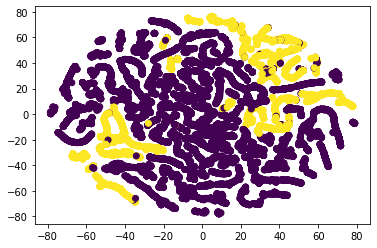

In [6]:
# Определяем модель и скорость обучения
tsne = TSNE(learning_rate=100)

# Обучаем модель
transformed = tsne.fit_transform(scaled_X)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=y)
plt.show()

## 5 Метод кластеризации на основе плотности DBSCAN

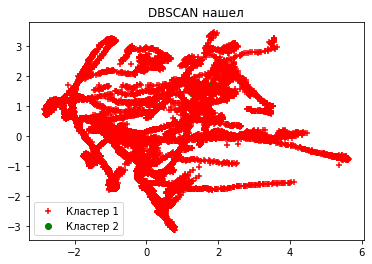

In [7]:
# Определяем модель
dbscan = DBSCAN()

# Обучаем
dbscan.fit(scaled_X)

# Уменьшаем размерность при помощи метода главных компонент
pca = PCA(n_components=2).fit(scaled_X)
pca_2d = pca.transform(scaled_X)

# Строим в соответствии с двумя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')

plt.legend([c1, c2], ['Кластер 1', 'Кластер 2'])
plt.title('DBSCAN нашел')
plt.show()